# R&D Wald Estimator

## Генерация данных

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import time

from linearmodels.iv import IV2SLS as IV2SLS_linear
from causalml.inference.iv import BaseDRIVLearner
from sklearn.linear_model import LinearRegression

import dowhy
from dowhy import CausalModel

from hypex import ABTest
from hypex.dataset import Dataset, InfoRole, TargetRole, TreatmentRole

from data_gen_wald import DataGenerator

from WaldEstimator import WaldEstimator

from scipy import stats
from scipy.stats import ttest_ind


import warnings
warnings.filterwarnings("ignore")

%load_ext IPython.extensions.autoreload
%autoreload 2

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


Нормальные X и y, слабые корреляции

In [3]:
gen1 = DataGenerator(
    n_samples=2000,
    distributions={
        "X1": {"type": "normal", "mean": 0, "std": 1},
        "X2": {"type": "bernoulli", "p": 0.5},
        
        "y0": {"type": "normal", "mean": 5, "std": 1},
    },
    time_correlations={"X1": 0.2, "X2": 0.1, "y0": 0.3},
    effect_size=0.0,
    seed=7
)

Высокая автокорреляция и гамма-распределение для Y

In [4]:
gen2 = DataGenerator(
    n_samples=2000,
    distributions={
        "X1": {"type": "normal", "mean": 1, "std": 2},
        "X2": {"type": "bernoulli", "p": 0.3},
        "y0": {"type": "gamma", "shape": 2.0, "scale": 3.0},
    },
    time_correlations={"X1": 0.8, "X2": 0.4, "y0": 0.9},
    effect_size=0.15,
    seed=7
)

Сильно смещенное распределение X1 и слабый эффект

In [5]:
gen3 = DataGenerator(
    n_samples=3000,
    distributions={
        "X1": {"type": "normal", "mean": 10, "std": 5},
        "X2": {"type": "bernoulli", "p": 0.7},
        "y0": {"type": "normal", "mean": 0, "std": 1},
    },
    time_correlations={"X1": 0.5, "X2": 0.4, "y0": 0.6},
    effect_size=0.25,
    seed=7
)

Сильный эффект и Bernoulli-переменные

In [6]:
gen4 = DataGenerator(
    n_samples=1500,
    distributions={
        "X1": {"type": "bernoulli", "p": 0.2},
        "X2": {"type": "bernoulli", "p": 0.6},
        "y0": {"type": "normal", "mean": 3, "std": 2},
    },
    time_correlations={"X1": 0.2, "X2": 0.5, "y0": 0.4},
    effect_size=0.4,
    seed=7
)

Гамма Y, нормальный X1, умеренный эффект

In [7]:
gen5 = DataGenerator(
    n_samples=2500,
    distributions={
        "X1": {"type": "normal", "mean": 0, "std": 3},
        "X2": {"type": "bernoulli", "p": 0.5},
        "y0": {"type": "gamma", "shape": 5.0, "scale": 1.0},
    },
    time_correlations={"X1": 0.3, "X2": 0.2, "y0": 0.85},
    effect_size=1.0,
    seed=7
)

Малый эффект при нормальных X и Y

In [8]:
gen6 = DataGenerator(
    n_samples=5000,
    distributions={
        "X1": {"type": "normal", "mean": -1, "std": 1},
        "X2": {"type": "normal", "mean": 4, "std": 1},
        "y0": {"type": "normal", "mean": 8, "std": 2},
    },
    time_correlations={"X1": 0.4, "X2": 0.3, "y0": 0.9},
    effect_size=1.3,
    seed=7
)


Гамма-распределённые X и Y (тяжёлые хвосты)

In [9]:
gen7 = DataGenerator(
    n_samples=2000,
    distributions={
        "X1": {"type": "gamma", "shape": 2, "scale": 1},
        "X2": {"type": "normal", "mean": 3, "std": 1},
        "y0": {"type": "gamma", "shape": 2, "scale": 2},
    },
    time_correlations={"X1": 0.5, "X2": 0.5, "y0": 0.6},
    effect_size=2.0,
    seed=7
)

Очень высокая автокорреляция Y (практически консервативная метрика)

In [10]:
gen8 = DataGenerator(
    n_samples=4000,
    distributions={
        "X1": {"type": "normal", "mean": 0, "std": 1},
        "X2": {"type": "bernoulli", "p": 0.5},
        "y0": {"type": "normal", "mean": 10, "std": 1},
    },
    time_correlations={"X1": 0.2, "X2": 0.2, "y0": 0.95},
    effect_size=-0.5,
    seed=7
)

In [11]:
def generate_data(n):
    np.random.seed(42)
    #n = 5000

    Z = np.random.binomial(1, 0.5, size=n)                 # Инструмент
    X = np.random.normal(0, 1, size=(n, 3))                

    p_T = 0.3 + 0.4 * Z
    T = np.random.binomial(1, p_T)
    Y = 2 * T + X @ np.array([1.5, -2, 1]) + np.random.normal(0, 1, size=n)  # Потенциальный результат

    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3'])
    df['Z'] = Z
    df['T'] = T
    df['Y'] = Y
    return df



## Models

In [12]:

class LateEstimator:
    def __init__(self, df):
        self.df = df

    def _point_estimate(self, df):
        raise NotImplementedError("Метод _point_estimate должен быть реализован в подклассе")

    def run_with_time(self):
        start = time.time()
        
        # Основная оценка
        point_estimate = self._point_estimate(self.df)


        control_group = self.df[self.df['z'] == 0]['y']
        treat_group = self.df[self.df['z'] == 1]['y']
        stderr = np.sqrt(np.std(control_group)**2 / len(control_group) 
                         + np.std(treat_group)**2 / len(treat_group)
                         )

        t_stat = point_estimate / stderr
        ci_lower = point_estimate - 1.96 * stderr
        ci_upper = point_estimate + 1.96 * stderr
        p_value = stats.t.sf(np.abs(t_stat), df=len(self.df) - 1) * 2

        elapsed = time.time() - start

        return {
            'estimate': point_estimate,
            'stderr': stderr,
            'ci': (ci_lower, ci_upper),
            't_stat': t_stat,
            'p_value': p_value,
            'time': elapsed
        }


In [13]:
class HypexATEEstimator(LateEstimator):
    
    def _point_estimate(self, df):
        data = Dataset(
            roles={"z": TreatmentRole(), "y": TargetRole()},
            data=df,
            default_role=InfoRole()
        )
        test = ABTest()
        result = test.execute(data)
        return result
    
    def run_with_time(self):
        start = time.time()
        
        # Основная оценка
        point_estimate = self._point_estimate(self.df)        

        row = point_estimate.resume.data.iloc[0]
        t_stat = point_estimate._experiment_data.analysis_tables['TTest┴┴y'].data['statistic'].iloc[0]
        SE = abs(row["difference"] / t_stat)
        ci_lower = row["difference"] - 1.96 * SE
        ci_upper = row["difference"] + 1.96 * SE
        
        elapsed = time.time() - start

        return {
            'estimate': row['difference'],
            'stderr': SE,
            'ci': (ci_lower, ci_upper),
            't_stat': t_stat,
            'p_value': row['TTest p-value'],
            'time': elapsed
        }

        


In [14]:
class VanillaLATEEstimator(LateEstimator):
    
    def _point_estimate(self, df):
        ITT_y = df[df['z'] == 1]['y'].mean() - df[df['z'] == 0]['y'].mean()
        ITT_d = df[df['z'] == 1]['d'].mean() - df[df['z'] == 0]['d'].mean()
        return ITT_y / ITT_d if ITT_d != 0 else np.nan


In [15]:
class StatmodelsManualEstimator(LateEstimator):
    def _point_estimate(self, df):
        T = df['d']
        Y = df['y']
        first_stage = sm.OLS(T, sm.add_constant(df[['z', 'X1', 'X2']])).fit()
        df['T_hat'] = first_stage.fittedvalues

        second_stage = sm.OLS(Y, sm.add_constant(df[['T_hat', 'X1', 'X2']])).fit()
        return second_stage.params['T_hat']


In [16]:
class StatmodelsIV2SLSEstimator(LateEstimator):
    def _point_estimate(self, df):
        iv_model = IV2SLS(
            df['y'],
            sm.add_constant(df[['d', 'X1', 'X2']]),
            df[['z', 'X1', 'X2']]
        )
        result = iv_model.fit()
        return result.params['d']

In [17]:
class LinearIVEstimator(LateEstimator):
    def _point_estimate(self, df):
        model = IV2SLS_linear.from_formula('y ~ 1 + X1 + X2 + [d ~ z]', data=df)
        result = model.fit()
        return result.params['d']

In [18]:
class CausalMLEstimator(LateEstimator):
    def _point_estimate(self, df):
        learner = BaseDRIVLearner(learner=LinearRegression())
        learner.fit(
            X=df[['X1', 'X2']],
            treatment=df['d'],
            y=df['y'],
            assignment=df['z']
        )
        ate_dict = learner.estimate_ate(
            X=df[['X1', 'X2']],
            treatment=df['d'],
            y=df['y'],
            assignment=df['z']
        )
        return ate_dict[0][0]

In [19]:
class DoWhyEstimator(LateEstimator):
    def _point_estimate(self, df):
        model = CausalModel(
            data=df,
            treatment='d',
            outcome='y',
            instruments=['z'],
            common_causes=['X1', 'X2']
        )
        estimand = model.identify_effect(proceed_when_unidentifiable=True)
        estimate = model.estimate_effect(
            estimand,
            method_name="iv.instrumental_variable",
            test_significance=False
        )
        return estimate.value

In [20]:

gens = [gen1,gen2,gen3,gen4,gen5,gen6,gen7,gen8]

dfs = [
    gen.generate().drop(columns=['y0', 'U', 'D', 'y1'])
    for gen in gens

]
df_names = [f"df_{i}" for i in range(len(dfs))]

estimators_classes = [
    HypexATEEstimator,
    WaldEstimator,
   # StatmodelsManualEstimator,
 #    StatmodelsIV2SLSEstimator,
    LinearIVEstimator,
#    # CausalMLEstimator,
 #   DoWhyEstimator
]

results = []

for df_idx, (df, df_name) in enumerate(zip(dfs, df_names)):
    for estimator_cls in estimators_classes:
        estimator = estimator_cls(df)  
        try:
            if estimator_cls.__name__ == 'WaldEstimator':
                res = estimator.estimate()
            else:
                res = estimator.run_with_time()
            results.append({
                "dataset": df_name,
                "estimator": estimator_cls.__name__,
                "estimate": res["estimate"],
                "stderr": res["stderr"],
                "ci_lower": res["ci"][0],
                "ci_upper": res["ci"][1],
                "t_stat": res["t_stat"],
                "p_value": round(res["p_value"], 4),
                "significant": res["p_value"] < 0.05,
                "time": res["time"]
            })
        except Exception as e:
            print(str(e))
            results.append({
                "dataset": df_name,
                "estimator": estimator_cls.__name__,
                "estimate": None,
                "stderr": None,
                "ci_lower": None,
                "ci_upper": None,
                "t_stat": None,
                "p_value": None,
                "significant": False,
                "time": None,
                "error": str(e)
            })

results_df = pd.DataFrame(results)


In [21]:
results_df 

,dataset,estimator,estimate,stderr,ci_lower,ci_upper,t_stat,p_value,significant,time
0,df_0,HypexATEEstimator,-0.071270,0.044123,-0.157751,0.015211,1.615257,0.1064,False,0.461755
1,df_0,WaldEstimator,-0.103039,0.044104,-0.189481,-0.016597,-2.336269,0.0196,True,0.006966
2,df_0,LinearIVEstimator,-0.103789,0.044082,-0.190190,-0.017389,-2.354469,0.0186,True,0.062005
3,df_1,HypexATEEstimator,-0.108898,0.193169,-0.487510,0.269714,0.563743,0.5730,False,0.333205
4,df_1,WaldEstimator,-0.157886,0.193278,-0.536704,0.220932,-0.816887,0.4141,False,0.007102
5,df_1,LinearIVEstimator,-0.147393,0.193181,-0.526029,0.231242,-0.762979,0.4456,False,0.043654
6,df_2,HypexATEEstimator,0.246738,0.036490,0.175218,0.318258,-6.761848,0.0000,True,0.371261
7,df_2,WaldEstimator,0.361820,0.036489,0.290302,0.433338,9.915780,0.0000,True,0.008032
8,df_2,LinearIVEstimator,0.361772,0.036477,0.290277,0.433267,9.917781,0.0000,True,0.066183
9,df_3,HypexATEEstimator,0.154155,0.104362,-0.050396,0.358705,-1.477109,0.1399,False,0.353121


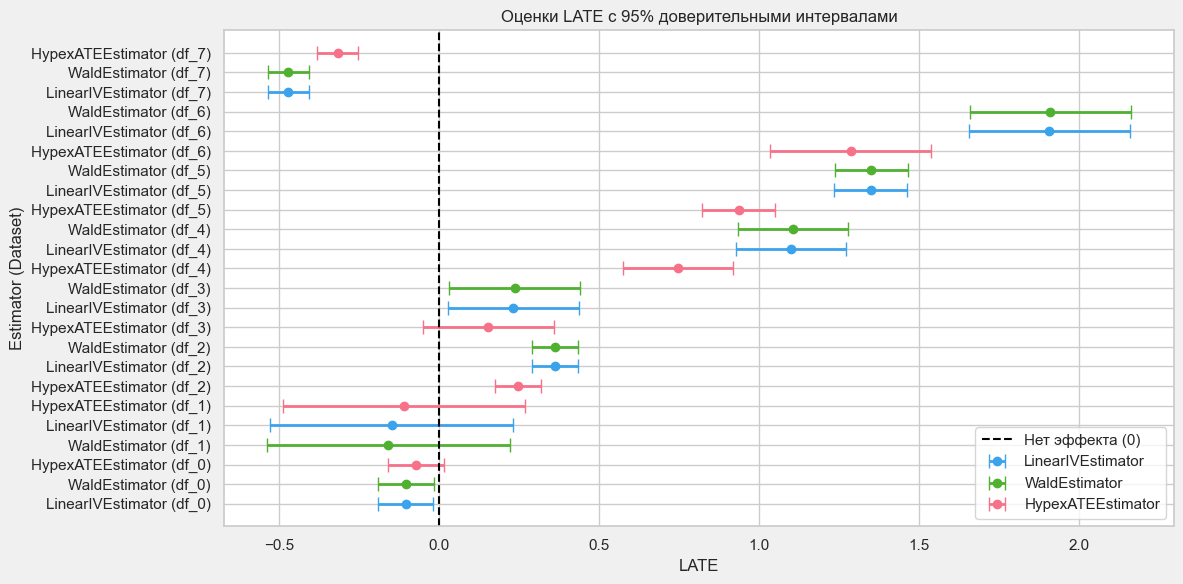

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

plot_df = results_df.dropna(subset=["estimate", "ci_lower", "ci_upper"]).copy()

plot_df["label"] = plot_df["estimator"] + " (" + plot_df["dataset"] + ")"

estimators = plot_df["estimator"].unique()
palette = sns.color_palette("husl", n_colors=len(estimators))  

estimator_color_map = {est: color for est, color in zip(estimators, palette)}
plot_df["color"] = plot_df["estimator"].map(estimator_color_map)

plot_df = plot_df.sort_values(by=["dataset","estimate"])

for i, row in plot_df.iterrows():
    plt.errorbar(
        x=row["estimate"],
        y=row["label"],
        xerr=[[row["estimate"] - row["ci_lower"]], [row["ci_upper"] - row["estimate"]]],
        fmt='o',
        color=row["color"],
        ecolor=row["color"],
        capsize=5,
        elinewidth=2,
        label=row["estimator"] if row["estimator"] not in plt.gca().get_legend_handles_labels()[1] else None
    )

plt.axvline(x=0, color='black', linestyle='--', label='Нет эффекта (0)')
plt.title("Оценки LATE с 95% доверительными интервалами")
plt.xlabel("LATE")
plt.ylabel("Estimator (Dataset)")
plt.legend()
plt.tight_layout()
plt.savefig("late_ci_plot.png", dpi=300)
plt.show()


In [23]:

estimator = WaldEstimator(
    df=dfs[0])

result = estimator.estimate(method='base')

print(estimator.summary())

print(f"LATE estimate: {result.estimate:.4f}")
print(f"95% CI: ({result.ci[0]:.4f}, {result.ci[1]:.4f})")

Method: base
Estimate: -0.1030
Std Error: 0.0441
95% CI: (-0.1895, -0.0166)
t-statistic: -2.3363
p-value: 0.019576
Time: 0.0114 seconds
LATE estimate: -0.1030
95% CI: (-0.1895, -0.0166)


In [24]:
result['stderr']